#Introduction

Hi, and welcome to this notebook tutorial, where we'll build a really, really good model for the KMNIST dataset using the [fastai](https://www.fast.ai/about/) library and [wandb](https://www.wandb.com/) visualization tools. If you haven't already, you should definetly check out the main article that this notebook is based on, which discusses all the techniques used here in detail.

I'll be taking through the code one step at time, and this entire notebook can be run end to end. So what are you waiting for? Run the cell below, and let's get started!

In [ ]:
%matplotlib inline

#Setup

The first thing we need to do is download wandb into our notebook instance. Wandb is a really powerful deep learning library that alllows us to monitor, visualize, and analyze our model's training progress without looking at weird numbers and hard-to-interpret graphs.

For the code to work properly, you're going to need a wandb account (it's free! you can sign up [here](https://app.wandb.ai/login?signup=true)) from which you'll need to create an API key to enter below. However, unlike most other lengthy API key creating processes, all you have to do here is follow the link that pops up. It should take you to a site that looks that this:

[IMAGE]

From there, copy the API key and paste it into the prompt that shows up when you run the below cell. And you're done. The wandb link is now set up, and you're good to go!

In [2]:
! pip install wandb
! wandb login

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 3.2 MB/s 
     |████████████████████████████████| 181 kB 41.2 MB/s 
     |████████████████████████████████| 158 kB 56.6 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 157 kB 60.3 MB/s 
     |████████████████████████████████| 157 kB 53.8 MB/s 
     |████████████████████████████████| 157 kB 65.4 MB/s 
     |████████████████████████████████| 157 kB 65.3 MB/s 
     |████████████████████████████████| 157 kB 57.3 MB/s 
     |████████████████████████████████| 157 kB 54.9 MB/s 
     |████████████████████████████████| 157 kB 72.4 MB/s 
     |████████████████████████████████| 156 kB 72.3 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=e0256dcd6f1ce43a24c080634d8d098720c1a030ba0aba3134a31baf1226ebba
  Stored in directory: /root/.cache/pip/wheels/3e/31/

Another quick thing we need to do is import all the python libraries required for this tutorial. Like, I mentioned, we're giong to use fastai and wandb.

In [19]:
from fastai import *
from fastai.vision import *
from torch.utils.data import Dataset
import wandb
from fastai.callback.wandb import *
from fastai.vision.data import ImageDataLoaders

import numpy as np

There's another little step we have to do to get wandb to work with our model, and that's to initialize it.

In [5]:
wandb.init()

wandb: Currently logged in as: michael_kingston. Use `wandb login --relogin` to force relogin


Since we're using the KMNIST dataset here, let's go ahead and clone the official repo for it. Note: this will not actually download the dataset. Instead, it'll provide a few helpful functions that'll help us dowload whatever we need when we need it.

In [6]:
! git clone https://github.com/rois-codh/kmnist.git
import os
os.chdir('kmnist')

Cloning into 'kmnist'...
remote: Enumerating objects: 211, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 211 (delta 0), reused 2 (delta 0), pack-reused 208
Receiving objects: 100% (211/211), 408.64 KiB | 8.51 MiB/s, done.
Resolving deltas: 100% (117/117), done.


#Kuzushiji-MNIST

The first dataset we're going to try out is KMNIST. This is a drop-in replacement for the original MNIST, with the same 10 classes and 70k images, but is harder to actually solve since it contains hard-to-read Japanese characters.

Of, we need to have the actual dataset before training a model on it. So let's download it straight to the notebook instance. The function below will start an interative download interface, where you'll have to select the dataset and format you want. We'll be using KMNIST in numpy format so choose those optons.

Select option 1 (KNIST) and then option 2 (NumPy format).

In [9]:
! python download_data.py

Please select a download option:
1) Kuzushiji-MNIST (10 classes, 28x28, 70k examples)
2) Kuzushiji-49 (49 classes, 28x28, 270k examples)
3) Kuzushiji-Kanji (3832 classes, 64x64, 140k examples)
> 1
Please select a download option:
1) MNIST data format (ubyte.gz)
2) NumPy data format (.npz)
> 2
100% 17954/17954 [00:30<00:00, 581.32KB/s] 
100% 30/30 [00:00<00:00, 182.96KB/s]
100% 3008/3008 [00:03<00:00, 918.35KB/s] 
100% 6/6 [00:00<00:00, 19538.68KB/s]
All dataset files downloaded!


Now that we have the entire dataset stored as numpy arrays, it should be fairly easy to work with. But there are two problem we need to work around.

The first problem is that the KMNIST dataset stores images in a single channel (since all images are grayscale). So we need to do some quick preprocessing to transform them into the more standard 3 channel RGB format so that they work with models pretrained on ImageNet.

In [10]:
train_imgs = np.load('kmnist-train-imgs.npz')['arr_0']  #.reshape((232365, 1, 28, 28))
train_labels = np.int64(np.load('kmnist-train-labels.npz')['arr_0'])

train_imgs = np.expand_dims(train_imgs,axis=1)
train_imgs = np.float32(np.repeat(train_imgs, 3, axis=1))

test_imgs = np.load('kmnist-test-imgs.npz')['arr_0']  #.reshape((38547, 1, 28, 28))
test_labels = np.int64(np.load('kmnist-test-labels.npz')['arr_0'])

test_imgs = np.expand_dims(test_imgs,axis=1)
test_imgs = np.float32(np.repeat(test_imgs, 3, axis=1))

The next issue is that fastai doesn't support numpy array images out of the box. So we need to create a new PyTorch dataset class which we can then wrap in a fastai databunch.

If you're not familiar with fastai or PyTorch, don't worry too much about what's going on here. You won't have to do this in most cases since you'll probably have regular images.

In [15]:
class NumpyArrayDataset(Dataset):
  
    def __init__(self, x, y):
        self.x, self.y = x, y
        self.c = np.unique(y).size # binary label
        self.classes = ["お", "き", "す", "つ", "な", "は", "ま", "や", "れ", "を"] 
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

After setting up the `NumPyArrayDataset` class, we'll now create our DataBunch, which is a fastai object that wraps a PyTorch training dataset, a PyToch validation dataset, and also assigns a batch size. Overall, a DataBunch will make it much easier for our model to interact with the datasets.

In [21]:
train_ds = NumpyArrayDataset(train_imgs, train_labels)
valid_ds = NumpyArrayDataset(test_imgs, test_labels)

data = ImageDataLoaders.from_folder(train_ds, valid_ds, bs=128)
data.normalize(imagenet_stats)

TypeError: ignored

If you want to submit your entry to the [official wandb KMNIST benchmark](https://app.wandb.ai/wandb/kmnist/benchmark), you have to rename the default accuray metric to `kmnist_val_acc`. They compute the same thing, just with different names.

In [ ]:
def kmnist_val_acc(): metrics.accuracy 

Now we're starting the fun stuff! In fastai, it's really easy to create a model and get started. Here, I'm going to create a 34 layer ResNet that's pretrained on ImageNet. In my experiments, this seemed to strike a good balance between training speed and accuracy. But feel free to try out any other architecture you want.

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)
learn.loss_func = torch.nn.functional.cross_entropy
learn.unfreeze()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 90812531.83it/s]


If you've read the main article (which you should have), you'll know what an important part the learning rate finder plays. Luckily, fastai makes it really easy to implent this in just 2 lines of code! There more details on what exactly we're doing here and why it works in the article, so finish reading it to get a clearer picture of the plots.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


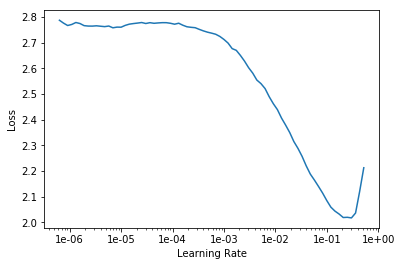

In [ ]:
learn.lr_find()
learn.recorder.plot()

Finally, we'll fit the model to our data, using the optimal learning rate of `1e-2` which we found using the plot above (the optimal learning rate is the one that produces the steepest slope in loss).

The wandb magic here is what helps keep us montor training. The coolest part is that your training statistics are uploaded to the eandb clous service in real time, so you keep this notebook running and watch how your model performs from [app.wandb.ai](https://app.wandb.ai).

If all goes well, your model should achive around 97% accuracy, which is pretty good!

In [ ]:
%%wandb
learn.fit_one_cycle(10, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.332265,0.569788,0.825800,00:39
1,0.181026,0.423954,0.881700,00:39
2,0.165461,0.389219,0.879100,00:39
3,0.130766,0.313490,0.908800,00:39
4,0.098722,0.255301,0.932900,00:39
5,0.085785,0.189655,0.946800,00:39
6,0.059579,0.166035,0.955200,00:39
7,0.036171,0.145391,0.962100,00:39
8,0.034838,0.135079,0.966600,00:39
9,0.021453,0.135671,0.967800,00:39


#Kuzushiji-49

Another, more complex variant of the KMNIST dataset is K-49, which as you could probaly tell from the name, has 49 possible classes. The method we use however, is pretty much the same.

Using the code for KMNIST above as a refernce, see if you can modify the code here to create an accurate model for K-49. In particular, I've left the `max_lr` argument on the `fit_one_cycle` function blank. Try using your understanding of the learning rate finder to fill it in and train the model.

One thing to note: K-49 has over 200k images, so your model might take much longer to train. But if you're patient enough, it should be possible to cross 80% accuracy using just this colab notebook.

In [ ]:
! python download_data.py

In [ ]:
train_imgs = np.load('k49-train-imgs.npz')['arr_0']#.reshape((232365, 1, 28, 28))
train_labels = np.int64(np.load('k49-train-labels.npz')['arr_0'])

train_imgs = np.expand_dims(train_imgs,axis=1)
train_imgs = np.float32(np.repeat(train_imgs, 3, axis=1))
#train_imgs = (train_imgs-train_imgs.mean()) / train_imgs.std()

test_imgs = np.load('k49-test-imgs.npz')['arr_0']#.reshape((38547, 1, 28, 28))
test_labels = np.int64(np.load('k49-test-labels.npz')['arr_0'])

test_imgs = np.expand_dims(test_imgs,axis=1)
test_imgs = np.float32(np.repeat(test_imgs, 3, axis=1))
#test_imgs = (test_imgs-test_imgs.mean()) / test_imgs.std()

In [ ]:
class NumpyArrayDataset(Dataset):
  
    def __init__(self, x, y):
        self.x, self.y = x, y
        self.c = np.unique(y).size
        self.classes = ["お", "き", "す", "つ", "な", "は", "ま", "や", "れ", "を"] 
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [ ]:
train_ds = NumpyArrayDataset(train_imgs, train_labels)
valid_ds = NumpyArrayDataset(test_imgs, test_labels)

data = ImageDataBunch.create(train_ds, valid_ds, bs=128)
data.normalize(imagenet_stats)

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy, callback_fns=WandbCallback)
learn.loss_func = torch.nn.functional.cross_entropy
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(10, max_lr=____)

#Kuzushiji-Kanji

The largest dataset of the three Japanese character datasets is the Kuzusshiji-Kanji dataset, which contains over 3000 classes and 100k images that have a 64x64 resolution.

The massive size of this dataset can make training extremely slow, so I'd reccomend you try it out in a faster V100 cloud instance via something like AWS or FloydHub.

But in a way, Kuzushiji-Kanji can be easier to work with, since the files are served as regular images. Play around with the below code yourself and see if you can get any interesting results.

In [ ]:
! python download_data.py

In [ ]:
import tarfile
tar = tarfile.open("kkanji.tar")
tar.extractall()
tar.close()

In [ ]:
data = ImageDataBunch.from_folder('kkanji2', valid_pct=0.2, bs = 1024)
data.normalize(imagenet_stats)

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=(accuracy,top_k_accuracy), callback_fns=WandbCallback)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.recorder.plot()

In [ ]:
%%wandb
learn.fit_one_cycle(10, max_lr=slice(3e-3,3e-1))

In [ ]:
learn.validate(metrics=(accuracy,top_k_accuracy))

#Conlusion

In this notebook, we trained a ResNet on the KMNIST Japanese characters dataset and got an accuracy of around 97%. If you completed that part, I'd reccomend you also try out the K-49 and Kuzushiji-Kanji datasets, for which we can use similar methods.

The other two datasets, however, are more complicated, so your model will take longer to train, and your accracy might not be as good as it was for KMNIST. But deep learning is all about experimentation, so keep trying different model architectures, hyperparametrs, and training metods; you might just set a new state-of-the-art result!

I hoped you enjoyed this tutorial, and learned a few things about how to effectively train neural nets not just for KMNIST, but any image dataset that you might use. If you want to learn more, definetly check out the article that's tied to this notebook, where I explain how the methods we use here work.

Till then, see ya!